## **Dimensionality Reduction and Clustering for Pairs Trading Selection** <a id='Top'></a>
##### Authors: Jerry Loh, Lian Kah Seng

In this project, we attempt to search for pairs of securities suitable for a mean-reversion pairs trading strategy using machine learning methods. In particular, we apply dimensionality reduction and clustering techniques to historical daily price data for a set of ETFs. 

# **Contents** 
1. <a href='#Motivation'>Motivation</a>
2. <a href='#Related/ReferencedWorks'>Related/Referenced Works</a>
3. <a href='#Datasets'>Datasets</a>
   1. <a href='#Datasets'>Explanation of Dataset</a>
   2. <a href='#DataPre-processing/ETL'>Data Pre-processing/ETL</a>
   3. <a href='#FeatureScaling'>Feature Scaling</a>
4. <a href='#Methodology'>Methodology</a>
   1. <a href='#DimensionalityReduction'>Dimensionality Reduction</a>
      1. <a href='#PCA'>PCA</a>
   2. <a href='#Clustering'>Clustering</a>
      1. <a href='#k-Means'>k-Means</a>
      2. <a href='#DBSCAN'>DBSCAN</a>
      3. <a href='#HierarchicalClustering'>Hierarchical Clustering</a>
   3. <a href='#Evaluation'>Evaluation of Results</a>
5. <a href='#Conclusion'>Conclusion</a>

## 1. Motivation <a id='Motivation'></a>

In financial markets, *pairs trading* is a trading strategy which involves two or more securities that behave similarly. For example, Coca-Cola and Pepsi stock may behave similarly in the stock market due to having similar underlying characteristics. As a result, a linear combination of the two stocks (for example long Coca-Cola and short Pepsi) in a portfolio might produce a *stationary, mean-reverting* set of data.

This can then be exploited by traders for profit. For example, when Coca-cola is relatively underpriced compared to Pepsi, traders can buy Coca-Cola and sell Pepsi stock, expecting the difference in price to eventually revert to a normalised level.

![Al-Naymat, Ghazi. (2013). Mining Pairs-Trading Patterns: A Framework. International Journal of Database Theory and Application. 6. 19-28. 10.14257/ijdta.2013.6.6.02.](img/figure1.png)
###### Image source: Al-Naymat, Ghazi. (2013). Mining Pairs-Trading Patterns: A Framework. International Journal of Database Theory and Application. 6. 19-28. 10.14257/ijdta.2013.6.6.02.

However, pairs that exhibit such properties are rare in practice. A computational to search for such pairs can speed up research greatly, given the large number of securities in the financial market. 
- A naive brute-force approach incurs a time complexity of $O(\frac{n(n-1)}{2})$, where $n = $ the number of securities tested
  - Such an approach is not only time inefficient, but the large number of statistical tests may also result in the *multiple comparisions problem*, leading to many Type I errors in our search
- Our approach is to apply dimensionality reduction (PCA) and clustering (KMeans, DBSCAN, Hierarchical Clustering) techniques on time series price data to search for groups of similar securities.
  - This reduces the number of statistical tests required, and improves computational efficiency.

## 2. Related/Referenced Works <a id='Related/ReferencedWorks'></a>

1. *A Machine Learning based Pairs Trading Investment Strategy* by Simão Moraes Sarmento and Nuno Horta (2021)
   - Sarmento and Horta explore unsupervised learning methods for pairs trading selection, in particular OPTICS for clustering. We attempt to explore other clustering methods such as KMeans, DBSCAN and Hierarchical Clustering for the same application.

2. *Pairs Trading: Quantitative Methods and Analysis* by Ganapathy Vidyamurthy (2004)
   - Vidyamurthy's book on pairs trading and statistical arbitrage was immensely helpful for the data processing step. In particular, Vidyamurthy's explanation of factor models for logarithmic stock returns provided a foundational understanding of pairs trading.

3. *Statistical Arbitrage in the U.S. Equities Market* by Marco Avellaneda and Jeong-Hyun Lee (2008) 
   - This paper by Avellaneda and Lee provided the motivation for the implementation of PCA for dimensionality reduction.

## 3.1 Datasets <a id='Datasets'></a>
- The dataset used comes from financial data vendor *kibot.com*
  - .csv files of historical adjusted daily price data for 4088 ETFs
  - We chose a training period from 2015/01/01 to 2020/01/01, and a validation period from 2020/01/02 to 2022/01/02
</br>
</br>
- Due to some inconsistencies and missing data from the training period selected, we had to concatenate all 4088 files, then filter, clean and transform it into a suitable pandas DataFrame for use. 
  - This process is shown in the code blocks below.

## 3.2 Data Pre-processing/ETL <a id='DataPre-processing/ETL'></a>

In [1]:
import os
import glob
import math
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

'''Import data'''

class Constants: # object to store constants we need
    def __init__(self, directory, start_train, end_train, start_test, end_test):
        self.path = os.path.join(os.getcwd(), directory, "")
        self.start_train = start_train
        self.end_train = end_train
        self.start_test = start_test
        self.end_test = end_test

def get_paths(fpath, extension=""):
    '''
    returns dictionary of {stock_name:path_to_csv}
    '''
    all_files = glob.glob(fpath + f"/*{extension}") # get all paths in directory 
    return {os.path.basename(v):v for v in all_files}

def get_dataframes(constants):
    start_train = dt.datetime.strptime(constants.start_train, "%Y-%m-%d")
    end_train = dt.datetime.strptime(constants.end_train, "%Y-%m-%d")
    end_test = dt.datetime.strptime(constants.end_test, "%Y-%m-%d")
    paths = get_paths(constants.path)
    epsilon = 0.0000001

    df_list = []
    for symbol, path in paths.items():
        df = pd.read_csv(path, parse_dates=["Date"])

        if len(df) == 0: # remove empty df
            continue
        elif df["Date"].iloc[0] >= start_train or df["Date"].iloc[-1] <= end_test: 
            # make sure our time series is in the date range from start_train to end_test
            continue
        try:
            df["Close"] = pd.to_numeric(df["Close"])
        except ValueError as e: # check for non-numeric in the feature set, and remove df if present
            continue
        else:
            df["Close"]= df["Close"].add(epsilon) # add epsilon to avoid zero division error 
            df = df.set_index("Date", drop=True) # set date column as datetimeindex
            df[symbol] = np.log(df["Close"]/df["Close"].shift(1)) # calculate daily logarithmic return and name the column by symbol
            log_returns = df[symbol]
            log_returns = log_returns[start_train:end_train] # filter our time series to the training period only 
            log_returns = log_returns.dropna() # drop nans
            df_list.append(log_returns)

    return df_list


'''Set up paths / train/test period here'''
constants = Constants(
    directory="etf_data",
    start_train="2015-01-01",
    end_train="2020-01-01",
    start_test="2020-01-02",
    end_test="2022-01-02"
)

df_list = get_dataframes(constants)
print("Example dataframe of logarithimic returns:\n", df_list[1])

Example dataframe of logarithimic returns:
 Date
2015-01-02   -0.000923
2015-01-05    0.034572
2015-01-06    0.016521
2015-01-07   -0.025001
2015-01-08   -0.037647
                ...   
2019-12-24    0.002671
2019-12-26   -0.006691
2019-12-27   -0.001792
2019-12-30    0.012476
2019-12-31   -0.004438
Name: DXD, Length: 1258, dtype: float64


1. Now that we have a list of dataframes of each ETF, we concatenate them along columns, then clean it
2. Then we take the transpose such that each column (feature) of the dataframe represents a date 

In [2]:
cat = pd.concat(df_list,axis=1)
cat = cat.dropna(axis=1, thresh=int(len(cat)*0.75)) # we require that at least 75% of the data is present 
cat = cat.bfill(axis=1) # fill nans by backfilling
cat_T = cat.transpose()
cat_T = cat_T.dropna(axis=1)

print("Concatenated dataframe along columns:\n", cat.iloc[:5,:5]) 
print("\nTaking the transpose:\n", cat_T.iloc[:5,:5])
print("\nDimension of cat_T:", cat_T.shape)


Concatenated dataframe along columns:
                  GDX       DXD       AGG       BRF       FXI
Date                                                        
2015-01-02  0.026564 -0.000923  0.002897 -0.021288  0.000853
2015-01-05  0.028705  0.034572  0.002034 -0.038846 -0.003131
2015-01-06  0.051858  0.016521  0.002670 -0.009725 -0.012045
2015-01-07 -0.019002 -0.025001 -0.000427  0.017578  0.025916
2015-01-08 -0.014505 -0.037647 -0.001602  0.014270  0.007562

Taking the transpose:
 Date  2015-01-02  2015-01-05  2015-01-06  2015-01-07  2015-01-08
GDX     0.026564    0.028705    0.051858   -0.019002   -0.014505
DXD    -0.000923    0.034572    0.016521   -0.025001   -0.037647
AGG     0.002897    0.002034    0.002670   -0.000427   -0.001602
BRF    -0.021288   -0.038846   -0.009725    0.017578    0.014270
FXI     0.000853   -0.003131   -0.012045    0.025916    0.007562

Dimension of cat_T: (1124, 1252)


## 3.3 Feature Scaling <a id='FeatureScaling'></a> 
- We apply standardisation to the dataset
  - We choose standardisation because:
    - We have unbounded, quantitative continuous values (log returns)
    - It is common to make the assumption of log-normal prices, which implies that log returns follow a gaussian distribution

- The standardisation algorithm is: $ x' = \frac{x-\mu}{\sigma} $


In [3]:
'''
cat_T.values returns a np.array of log returns
We will standardise these log returns using StandardScaler
'''

norm = StandardScaler().fit_transform(cat_T.values)
norm_symbols = cat_T.index

print("Values before standardisation:\n", cat_T.values[:3])
print("\nValues after standardisation:\n", norm[:3])
print(np.mean(norm).round(1), np.var(norm).round(1))

Values before standardisation:
 [[ 2.65640176e-02  2.87048327e-02  5.18579837e-02 ... -6.70788038e-03
   2.03373068e-02 -5.91820698e-03]
 [-9.23393893e-04  3.45716890e-02  1.65214242e-02 ... -1.79179406e-03
   1.24756564e-02 -4.43774581e-03]
 [ 2.89746406e-03  2.03393529e-03  2.66994338e-03 ...  1.29545683e-03
   9.24684451e-05 -2.31428013e-03]]

Values after standardisation:
 [[ 2.1789812   1.77392678  3.10486993 ... -0.88420812  2.82510837
  -1.26633677]
 [ 0.0690127   2.03137098  1.20124231 ... -0.22239442  1.85173075
  -1.02148636]
 [ 0.36230659  0.60357809  0.45504456 ...  0.19321768  0.31852622
  -0.67029077]]
0.0 1.0


## 4.1 Methodology: Dimensionality Reduction <a id='Methodology'></a>

### 4.1.1 Dimensionality Reduction with PCA <a id='DimensionalityReduction'></a> <a id='PCA'></a>

### **What is PCA?** 

PCA is an **unsupervised learning** technique that reduces the dimensionality of large data sets by simplifying data, reducing noise and transforming them into smaller *principal components*, while best retaining information in the original dataset. PCA creates *new principal components (PCs*)*, which are uncorrelated, linear combinations of features in the original dataset that maximise variance.
<br/>
<br/>
Due to the sheer size of our dataset, one of our main concerns was time and space efficiency. In addition, the high number of features in our dataset would likely cause our model to overfit. Thus, we applied dimensionality reduction, using PCA, prior to any clustering methods to mitigate these concerns
<br/> 
* Steps involved
     1. For a $N\times M$ dataset with $M$ features, a $M\times M$ covariance matrix is formed (The $\left(i,j\right)$-entry of the covariance matrix is the covariance between the $i^{th}$ and $j^{th}$ features)
     2. the covariance matrix is diagonalised to obtain its eigenvalues in descending order
     3. Choosing the n largest eigenvectors, a $M\times n$ matrix can be formed, which is post-multiplied to the original dataset to obtain a $N\times n$ PCA matrix

- In our selection of the number of principal components, we used an elbow method to find the best balance between total variance explained and the number of dimensions.

**PCA CODE**
</br>
* the function `optimise_pca(norm)` calculates the total variance explained for a given number of principal components. for our dataset, we calculated this value for components in `range(0,50,1)`. their respective values are then plotted on a graph. this is done to find the optimal number of principal components to be chosen. this is done through finding the "elbow" of the graph. in the case of our dataset, n = 17
</br>
</br>
* from `sklearn.decomposition`, we imported `PCA`. our function `pca(norm,symbols,n)` uses the PCA module to reduce the number of features in a given data set to n *PCs*. in the case of our dataset, we reduced the features in our data set to 17 principal components, and returned **pca_df**. which is the dataset that has undergone dimensionality reduction

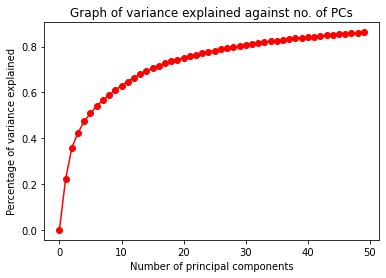

Total percentage variance explained with 17 principal components: 0.727


            PC1        PC2        PC3        PC4       PC5
GDX    4.268221 -51.277805 -10.480102  -8.524085  0.649144
DXD   43.018170  -5.458323   4.651520   3.484968  0.952025
AGG   12.690767  -1.213626  -1.368500   0.835437 -0.575150
BRF  -11.206257 -12.641719   8.621291  23.878764 -7.124370
FXI  -12.890127  -0.349350  -0.633938  12.915047  4.973797
...         ...        ...        ...        ...       ...
IFV   -6.877754  -2.149095  -0.108776   8.001788  0.706747
STIP  11.830796  -0.143538   0.335296   0.264470  0.242482
ERUS -13.748025  -8.015132  15.943814   5.850051  1.744766
XHE   -5.242339   5.318019  -8.142536  -4.727296 -3.060412
CEW    6.089911  -3.421382   1.917324   3.624886  0.457347

[1124 rows x 5 columns]


In [4]:
'''
Dimensionality Reduction with PCA before we apply any clustering algos: 
'''

def optimise_pca(norm):
    explained_var = []
    principal_components = []
    for i in range(0,50,1): # optimise the number of dimensions chosen based on elbow method
        pca_model = PCA(n_components=i)
        pca_model.fit_transform(norm)
        explained_var.append(sum(pca_model.explained_variance_ratio_))
        principal_components.append(i)
    
    plt.plot(principal_components, explained_var, color="red", marker="o")
    plt.title("Graph of variance explained against no. of PCs")
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage of variance explained")
    plt.show()

def pca(norm, symbols, n):
    pca_model = PCA(n_components=n)
    components = pca_model.fit_transform(norm)

    #print(f"{n} largest eigenvalues of the covariance matrix:\n{pca_model.explained_variance_}")
    #print(f"Percentage of variance explained by each component:\n{pca_model.explained_variance_ratio_}")
    print(f"Total percentage variance explained with {n} principal components: {round(sum(pca_model.explained_variance_ratio_),3)}\n")
    print()
    pca_df = pd.DataFrame(components, columns=[f"PC{k}" for k in range(1,n+1)],index=symbols)
    return pca_df

optimise_pca(norm) # from the graph, choose n=17 as best number of dimensions

pca_df = pca(norm, norm_symbols, n=17)
print(pca_df.iloc[:,:5])

### Visualising the PCA

- We visualise the PCA in $\R^2$ below.
  - Note that the actual number of dimensions we have is not just 2, but it is difficult to visualise beyond dimension 2
- Each point represents an ETF
  - We can now use clustering methods to group points close together into potential pairs trading pairs.

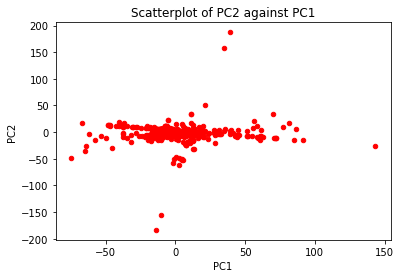

In [5]:
'''
Visualising the PCA in dimension R^2 (PC1 and PC2)
'''

fig, ax = plt.subplots()
pca_df.plot(x="PC1", y="PC2", kind="scatter", 
    title="Scatterplot of PC2 against PC1", ax=ax, color="r")
#for k, _ in pca_df.iterrows():
#    ax.annotate(k,_)
plt.show()


## 4.2 Methodology: Clustering <a id='Clustering'></a>

### 4.2.1 Clustering with k-Means <a id='k-Means'></a>

### **What is k-Means Clustering?**
k-Means Clustering is an unsupervised learning technique that, for a chosen value of k, identifies k clusters of objects based on the objects’ proximity to the centre of the k groups. The centre is determined as the arithmetic average of each cluster’s n-dimensional vector of feature variables. One of the big advantages of k-Means Clustering is how easy it is to implement. It also always converges.
<br/>
<br/> 
* **Steps** involved
     1. a k-value is chosen (this determines the number of clusters)
     2. k data points are chosen as the centroids
     3. other data points are assigned/grouped (labeled) to respective centroids (based on whichever centroid they are the closest to)
     <br/> 
     <br/> 
     *for a given data-set of M data points, with p feature variables/attributes such that the *i*-th data point has the coordinates of ($x1_i$,$x2_i$,...$xp_i$)*, 
     <br/> 
     <br/> 
     *for the *Dc*-th centroid chosen, with the coordinates ($x1_{Dc}$,$x2_{Dc}$,...$xp_{Dc}$), the euclidean distance between any given *i*-th data point, where $i \in 1,2,...,M$, and any given *d*-th centroid, where $c \in 1,2,...,k$ is given by*:
     <br/> 
     <br/> 
     $\sqrt{\sum_{j=1}^p (xj_i-xj_{Dc})^2}$
     <br/> 
     <br/> 
     1. after all the data points have been assigned/grouped(labeled), in each cluster, a new centroid coordinate is generated. this is the calculated using the mean of all the coordinates within that particular cluster.
     <br/> 
     *the new centroid for a cluster with z points is given by:*
     <br/> 
     <br/> 
     $(\frac{1}{m} \sum_{i=1}^z x1_i,\frac{1}{m} \sum_{i=1}^z x2_i,...,\frac{1}{m} \sum_{i=1}^z xp_i)$
     <br/> 
     <br/> 
     1. steps 3 and 4 are then repeated till convergence *(this can be done either through setting a limit on the number of recursions or by repeating until the coordinates centroids only change by a small amount (0.01), or until the data points stay within the same cluster for a few repetitions)*
<br/> 
<br/> 
* More pointers
     1. the k-value can be chosen via a variety of techniques, one way is through Within Sum of Squares (WSS).
     2. for each centroid, the sum of squared distances from each of the points within the cluster is calculated  
     3. these values are then summed up together and plotted onto a graph
     <br/> 
     <br/> 
     *for a data set with M points and p feature variables/attributes, the WSS is calculated via:*   
     <br/> 
     $\sum_{i=1}^M \sum_{j=1}^p (xj_i-xj_{Dc})^2$
     <br/>
     <br/>
     *given that the *D*-th centroid has the coordinates ($x1_{Dc}$,$x2_{Dc}$,...$xp_{Dc}$)* 
<br/>
<br/>
* **Limitations**
     1. requires specification of the number of clusters
     2. unable to handle outliers and noisy data
     3. cannot be used for categorical data

- In our selection of the hyperparameter $k$ (number of clusters), we used an elbow method to find an optimal balance between reducing the sum of squared distances and the value of k

**k-Means Code**
</br>
* from `sklearn.cluster` we imported `KMeans`. the function `optimise_k(pca_df)`, using `.intertia_` and `KMeans`, it calculates the within sum of squares for a given k value. 
</br>
</br>

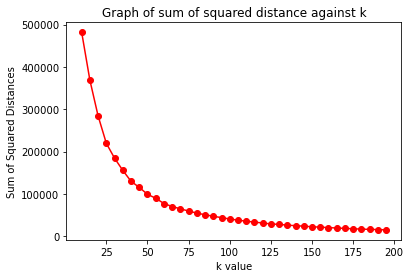

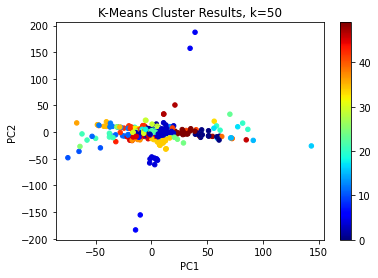

In [6]:
'''make a pointer to store clustering results'''

cluster_results = {}

'''K-Means Clustering'''

def optimise_k(pca_df):
    '''
    Elbow method to find optimal value of k
    '''
    error = []
    ks = []
    for i in range(10, 200, 5):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(pca_df)
        error.append(kmeans.inertia_)
        ks.append(i)
    
    # plot error for elbow method
    plt.plot(ks, error, marker="o", color="r")
    plt.title("Graph of sum of squared distance against k")
    plt.xlabel("k value")
    plt.ylabel("Sum of Squared Distances")

def cluster_kmeans(pca_df, k):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pca_df)
    results = kmeans.predict(pca_df)

    # plot cluster results
    fig, ax = plt.subplots()
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"K-Means Cluster Results, k={k}", c=results, cmap="jet", ax=ax)
    plt.show()
    return results

optimise_k(pca_df) # elbow point at k=50
kmeans_results = cluster_kmeans(pca_df,k=50)

cluster_results[f"KMeans"] = kmeans_results

### 4.2.2 Clustering with DBSCAN <a id='DBSCAN'></a>

### **What is DBSCAN?**
DBSCAN is an unsupervised learning technique that clusters based on a density metric. In the case of DBSCAN, not all data points will belong to a cluster at the end of the process. Data points belonging to no cluster will be labelled as outliers and noise. This property alone allows us to overcome the limitations of k-Means. One of other big advantages of DBSCAN is its ability to find arbitrarily sized & arbitrarily shaped clusters. In order to discuss how DBSCAN works, we first have to define certain key terms and underlying fundamental concepts.
<br/> 
<br/> 
* Definitions
     1. Firstly, ε-neighborhood. The ε-neighborhood of a point, $q$, is defined as:
     <br/>
     <br/>
     $N_\varepsilon(q) = \{p \in X|d(q,p) \leq \varepsilon \}$
     <br/>
     <br/>
     2. Corepoint: A point q is core point if it verifies 
     <br/>
     <br/>
     $|N_\varepsilon(q)| \geq minPts$
     <br/>
     <br/>
     where $|N_\varepsilon(q)|$ the number of points within the ε-neighborhood of $q$. $minPts$ accounts for the point itself.
     <br/>
     <br/>
     3. Directly density-reachable: Point p is directly density-reachable from point $q$ in a set of points $X$ provided that $p \in N_\varepsilon(q)$ and $q$ is a core point.
     4. Density-reachable: A point $p$ is density-reachable from a point $q$ if there is a chain of objects $p_1,..., p_n$, where $p_1 = q$ and $p_n = p$ such that $p_{i+1}$ is directly density-reachable from $p_i$ .
     5. Density-connected: A point $p$ is density-connected to a point $q$ if both points are density-reachable from a common core point.
<br/>
<br/>
To summarise, DBSCAN clusters are based on two criterias. One, all points within a cluster are mutually density-connected. Secondly, if a point is density-reachable from any point of the cluster, it must belong to the cluster
<br/>
<br/>
* **Steps** involved
     1. Find the points in the ε-neighborhood of every point and identify the core points with more than $minPts$ neighbours.
     2. Find the connected components of core points on the neighbour graph, ignoring all non-core points.
     3. Assign each non-core point to a nearby cluster if the cluster is an ε-neighbor, otherwise assign it to noise.
<br/>
<br/>
* **Limitations**
     1. very sensitive to its parameters, namely the definition of $\varepsilon$
     2. the clusters are assumed to be evenly densed, which means the clusters that are formed will also be evenly densed (no variance in cluster density)
     3. for a given $\varepsilon$, it might work well for a cluster of a given denstiy but not as much for another cluster with a different density in the same dataset

- In our selection of the hyperparameter $\epsilon$, we used an optimisation algorithm (Elbata 2012) which finds the elbow point of a graph of the sorted distances to the nearest neighbour of each data point

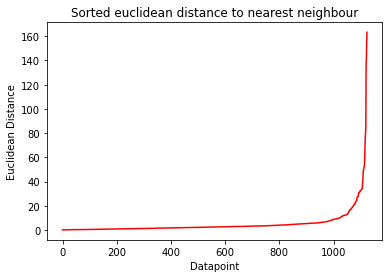

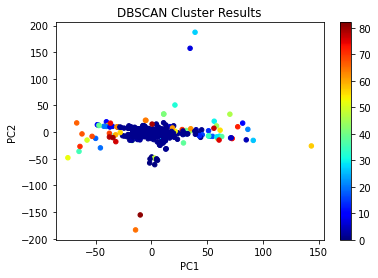

Number of Clusters: 82


In [7]:
'''
DBSCAN Clustering:
'''

def optimise_epsilon(pca_df):
    '''
    Elbow method to find optimal value of epsilon
    '''
    neigh = NearestNeighbors(n_neighbors=2) # find pa
    nbrs = neigh.fit(pca_df)
    distances = nbrs.kneighbors(pca_df)[0]
    distances = np.sort(distances,axis=0) # sort distances row-wise
    distances = distances[:,1:] # remove the 0 value (euclidean distance to itself)

    plt.plot(distances, color="r")
    plt.title("Sorted euclidean distance to nearest neighbour")
    plt.xlabel("Datapoint")
    plt.ylabel("Euclidean Distance")
    plt.show()    

def cluster_dbscan(pca_df, eps, min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    #dbscan.fit(pca_df)
    results = dbscan.fit_predict(pca_df)
    
    fig, ax = plt.subplots()
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"DBSCAN Cluster Results", c=results, cmap="jet", ax=ax)
    plt.show()

    num_clusters = np.max(results) # get number of clusters
    print(f"Number of Clusters: {num_clusters}")

    return results

optimise_epsilon(pca_df) # from the graph, 15 is near elbow point
results = cluster_dbscan(pca_df, eps=15, min_samples=1)

cluster_results["DBSCAN"] = results


### 4.2.3 Clustering with Hierarchical Clustering <a id='HierarchicalClustering'></a>

### **What is Hierarchical Clustering?**
Hierarchical Clustering is an unsupervised learning technique that builds a hierarchy of clusters. It involves the generation of a dendrogram, a diagram that represents the hierarchical relationship between objects. The dendrogram also displays the distance between each pair of sequentially merged objects. There are two approaches to hierarchical clustering, mainly **Agglomerative** and **Divisive**. The one that was chosen for our data set was the Agglomerative approach.
* Agglomerative is a "bottom-up" approach where each data point is treated as its own cluster. Then an iterative process begins where pairs of clusters (that have identified to be the closest together / most similar) are merged (as it moves up the hierarchy).
* Divisive is a "top-down" approach where every single data point is first identified to be in one singular cluster. Then, an iterative processs begins where splits in the cluster are performed (as it moves down the hierarchy, based on a distance metric).
<br/>
<br/>
* **Steps** involved (Agglomerative)
     1. First, treat each data point as its own cluster, which will result in the formation of N clusters (Assuming there are a total of N data points)
     2. Take two closest data points and make them one cluster; this results in a total of N-1 clusters
     3. Step 2 is repeated until there is only one large cluster left
     4. Now, the order at which the clusters are formed (the hierarchy) results in the production of a dendrogram
<br/>
<br/>
* More pointers
     * to choose the number of optimal clusters, a dendrogram is plotted. then, a horizontal line that passes through longest distance without a horizontal line is drawn 
     * this allows the optimal number of clusters to be observed as total number of splits above the line = optimal number of clusters
<br/>
<br/>
* **Limitations**
     1. very sensitive to noise and outliers
     2. faces difficulties in handling clusters of different sizes
     3. ends up breaking large clusters
     4. once a decision is made to combine two clusters (or seperate into two clusters in the case of Divisive), it can't be undone
     5. ultimately, the location where the dendrogram is cut still has to be chosen. thus, if a bad value is chosen, the data obtained might not be the best


- For our study, we will choose the number of clusters $ n = \sqrt{N} $, where $N =$ number of datapoints


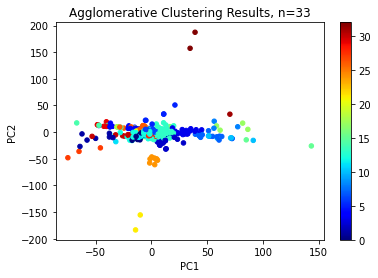

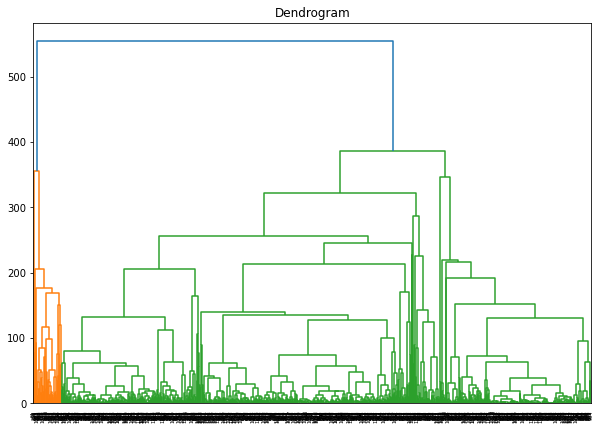

In [8]:
'''
Hierarchical Clustering (AgglomerativeClustering)
'''

def cluster_hierar(pca_df, n):
    hierar = AgglomerativeClustering(n_clusters = n,linkage= "ward").fit(pca_df)
    results = hierar.fit_predict(pca_df)

    # plot cluster results
    fig, ax = plt.subplots()
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"Agglomerative Clustering Results, n={n}", c=results, cmap="jet", ax=ax)
    plt.show()

    return results

def draw_dendrogram(pca_df,cut_off_value=None):
    linked = linkage(pca_df,method = "ward") #

    # plot dendrogram results
    plt.figure(figsize =(10,7))
    plt.title("Dendrogram")
    dendrogram(linked,
                orientation = "top",
                distance_sort = "descreasing",
                show_leaf_counts = True)
    #plt.axhline(y=cut_off_value, c='r')
    plt.show()

results = cluster_hierar(pca_df, int(pca_df.shape[0]**0.5)) # cut off dendogram at k=sqrt(N) clusters
draw_dendrogram(pca_df) # plot the cluster dendrogram
cluster_results["Hierarchical"] = results

## 4.3 Evaluation of Cluster Results <a id='Evaluation'></a>

- Since the usefulness of a cluster is dependent on the suitability of its members in a pairs trading strategy, we can compare the performance of each clustering algorithm by finding the pairwise correlation between stocks/ETFs in each cluster
- We evaluate our clustering results by measuring the average cluster R-Squared correlation of ETFs for each clustering algorithm.

In [9]:
'''
Cluster Results -> Groupings of stocks/ETFs:
1. First, we need to map the cluster ids to the symbols of our stocks to get groups of stocks
2. Then store the clusters into a pointer -> "groups"
'''

print(norm_symbols.shape) # array of the symbols of stocks
print([x.shape for x in cluster_results.values()]) # contains cluster group assignments for each algorithm

def map_clusters(cluster_result):
    grouping = [[] for _ in range(max(cluster_result)+1)]
    for i, res in enumerate(cluster_result):
        grouping[res].append(norm_symbols[i])
    
    grouping = [g for g in grouping if 1<len(g)<20] # keep clusters with <20 members 
    
    return grouping

groups = {}
for algorithm, cluster_result in cluster_results.items():
    groups[algorithm] = map_clusters(cluster_result)


print("Number of valid clusters:", {k:len(v) for k,v in groups.items()})
print("Example cluster:", groups["DBSCAN"][0])


(1124,)
[(1124,), (1124,), (1124,)]
Number of valid clusters: {'KMeans': 24, 'DBSCAN': 14, 'Hierarchical': 17}
Example cluster: ['GDX', 'SGDM', 'SLVP', 'SILJ', 'GOEX', 'SIL', 'RING', 'GDXJ']


In [10]:
'''
Evaluating cluster results by measuring pairwise correlation within each cluster in the validation period
'''

def get_r_squared(group, fpath, start_test, end_test):
    start_test = dt.datetime.strptime(start_test, "%Y-%m-%d")
    end_test = dt.datetime.strptime(end_test, "%Y-%m-%d")
    dfs = []
    for symbol in group:
        path = fpath+symbol
        df = pd.read_csv(path, parse_dates=["Date"])
        df = df.set_index("Date", drop=True)
        df[symbol] = np.log(df["Close"]/df["Close"].shift(1)) # log returns

        dfs.append(df[symbol])
    
    df = pd.concat(dfs, axis=1)
    df = df[start_test:end_test] # filter to validation period
    corr = df.corr() # correlation matrix
    corr.values[np.tril_indices_from(corr)] = np.nan # keep only upper triangular of the correlation matrix
    return corr.unstack().mean() # return mean of the correlation matrix

def average_correlation(groups, constants):
    avg_corr = {}
    for algorithm, cluster_result in groups.items():
        corrs = []
        for group in cluster_result:
            corr = get_r_squared(group, constants.path, constants.start_test, constants.end_test)
            corrs.append(corr)
        avg_corr[algorithm] = np.mean(np.square(corrs)) # take mean of r-squared 
    return avg_corr

corr_metrics = average_correlation(groups, constants)
pd.DataFrame(corr_metrics.items(), columns=["Algorithm", "R-Squared"])

,Algorithm,R-Squared
0,KMeans,0.762961
1,DBSCAN,0.892378
2,Hierarchical,0.746261


As shown, DBSCAN fares considerably better than k-Means and Hierarchical Clustering.

## Plotting Some Results

We plot the results for the clusters our DBSCAN algorithm found in the validation period.

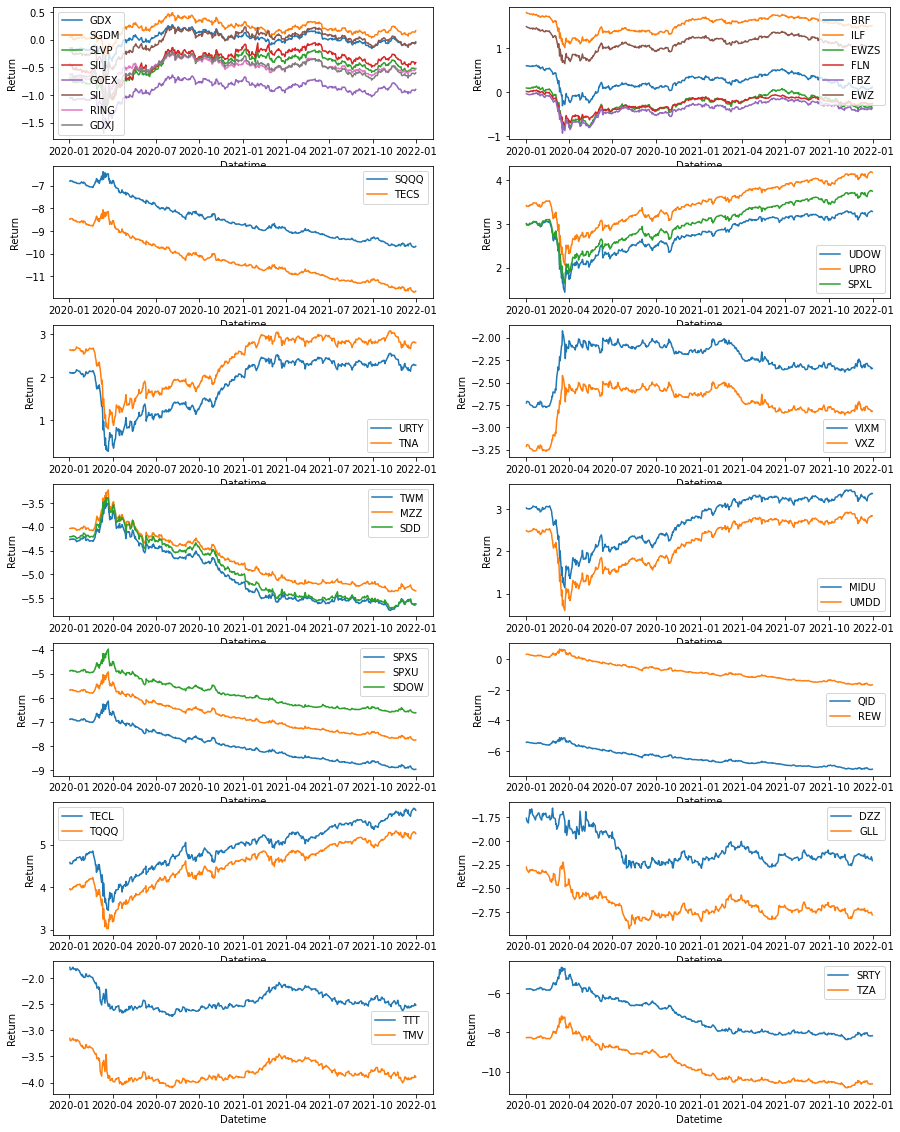

In [11]:
'''
Plot the stock prices of stocks from each cluster in the validation period
'''

def plot_time_series(group, i, fpath, start_test, end_test):
    start_test = dt.datetime.strptime(start_test, "%Y-%m-%d")
    end_test = dt.datetime.strptime(end_test, "%Y-%m-%d")
    
    for symbol in group:
        path = fpath+symbol
        df = pd.read_csv(path, parse_dates=["Date"])
        df = df.set_index("Date", drop=True)
        df["Log Return"] = np.log(df["Close"]/df["Close"].shift(1))
        df["Cumulative Log Return"] = df["Log Return"].cumsum()

        ax[i].plot(df["Cumulative Log Return"][start_test:end_test]) # plot validation period
        ax[i].set_xlabel("Datetime")
        ax[i].set_ylabel("Return")
    ax[i].legend(group)

# plot out clusters
group = groups["DBSCAN"]
num_clusters = len(group)

fig, ax = plt.subplots(math.ceil(num_clusters/2),2, figsize = (15,20))
ax = ax.ravel()
for i in range(0, num_clusters):
    plot_time_series(group[i], i, constants.path, constants.start_test, constants.end_test)
plt.show()

## 5. Conclusion <a id='Conclusion'></a>

The use of unsupervised dimensionality reduction and clustering techniques was successful in finding pairs of ETFs suitable for a pairs trading strategy. In particular, PCA and DBSCAN seems to be the most effective solution out of the methods tried in this study. As see from the plots above of some of the cluster groups from the DBSCAN results in the validation period of 2020/01/02 to 2022/01/02, we observe that each cluster of ETFs exhibit very similar price movements and behaviours. These would make good selections of pairs for a pairs trading strategy, which was our initial objective.

Just to reiterate, the selection of hyperparameters was done algorithmically, with the use of elbow methods for k-Means and DBSCAN, and the dendrogram for Hierarchical Clustering. This allowed us to optimise the algorithms for the best performance while avoiding serious overfitting. In addition, we also observed that increasing the number of principal components to keep at the dimensionality reduction stage improved the pairwise correlation metric mentioned above, leading to better performance. However, a choice of too many principal components leads to clusters of ETFs that are too similar and have too little variability, which is unsuitable for practical trading purposes. 

However, one possible area of improvement is the evaluation criteria used for comparing the three clustering algorithms. Instead of using the R-Squared correlation metric, tests for cointegration could be more suited to check for stationary series. Also, other methods to optimise hyperparameters for clustering algorithms could be explored in the future.   

<a href='#Top'>Go back to the top</a>